<a href="https://colab.research.google.com/github/tr-dev-bc/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter03/04_Steps_to_build_a_neural_network_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
data_folder = '~/data/FMNIST' # This can be any directory you want to
# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [13]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        # L2 flattens this into a vector (1D)
        # Flattening in the context of neural networks and image processing refers to the process of converting a multi-dimensional array (like an image) into a one-dimensional array (a vector).
        # In many neural network architectures, especially when using fully connected layers (also known as dense layers), the input needs to be a one-dimensional vector. Flattening allows you to convert the 28x28 pixel images into a single vector of 784 elements (28 * 28 = 784).
        # While flattening changes the structure of the data, it preserves all the pixel values. The model learns from these values, and the spatial relationships among pixels are often captured in the earlier convolutional layers.
        x = x.float()
        # In PyTorch, the view() method is used to reshape a tensor without changing its data. It allows you to specify new dimensions for the tensor, as long as the total number of elements remains the same.
        # A tuple representing the desired dimensions. You can use -1 as a placeholder for one of the dimensions, which allows PyTorch to automatically calculate that dimension based on the total number of elements.
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        # Flattening involves rearranging the pixel values into a single row per image. The pixel data itself remains the same; it's just represented in a different format.
        # if the first image (before flattening) is associated with label 0, after flattening, the first row of x (the flattened image) will still correspond to the same label in y at index 0.
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [14]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl
    '''The DataLoader class in PyTorch is designed to:
    Load data from a dataset.
    Batch data into manageable sizes.
    Shuffle the data at each epoch (if specified).
    Utilize parallelism to load data, improving performance.'''

In [15]:
from torch.optim import SGD
def get_model():
    # nn.Sequential: This is a container module in PyTorch that allows you to build a neural network layer by layer in a sequential manner.
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device) # This moves to the GPU to make it faster
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2) # model.parameters() retrieves all the parameters of the model that need to be optimized.
    return model, loss_fn, optimizer

In [16]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

In [17]:
@torch.no_grad() # This is a decorator that disables gradient calculation. This is useful during evaluation or inference to save memory and computations, as you don’t need to compute gradients for model weights.
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section This is important for layers like dropout and batch normalization, which behave differently during training and evaluation.
    # OUTPUT: PREDICTION BASED ON x THRU Model
    prediction = model(x)
    # This line finds the maximum value in each row of the prediction tensor along the last dimension (which typically corresponds to the class scores).
    # max_values will contain the maximum scores, while argmaxes will contain the indices of those maximum values, representing the predicted class for each input.
    max_values, argmaxes = prediction.max(-1)
    # This checks if the predicted class indices (argmaxes) match the true class labels (y).
    # It creates a tensor of boolean values indicating whether each prediction was correct.
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

**Let's dive deeper into these two lines:**

1. max_values, argmaxes = prediction.max(-1)

    **Purpose:** This line finds the maximum values and their corresponding indices from the prediction tensor along a specified dimension.

    **Breaking it Down:**
        prediction: This tensor typically has a shape of (batch_size, num_classes) where each row corresponds to a single input (e.g., an image) and each column corresponds to the predicted score for a particular class.
        max(-1): The -1 indicates that we want to perform the operation along the last dimension of the tensor (the class scores). This is the same as saying to compute the maximum values for each row of the tensor.

    **Outputs:**
        max_values: This tensor contains the maximum score for each input. It's useful for understanding how confident the model is in its predictions.
        argmaxes: This tensor contains the indices of the maximum scores. These indices represent the predicted class for each input sample in the batch.

**Example:**

Assume prediction has the following values for a batch of 3 samples and 4 classes:

'''csharp

prediction = [
    [0.1, 0.5, 0.2, 0.3],  # Sample 1
    [0.3, 0.1, 0.4, 0.2],  # Sample 2
    [0.0, 0.9, 0.1, 0.0]   # Sample 3
]

    Applying max(-1) gives:
        max_values = [0.5, 0.4, 0.9] (the highest scores for each sample)
        argmaxes = [1, 2, 1] (the indices of the maximum scores, representing predicted classes)

2. is_correct = argmaxes == y

    Purpose: This line checks if the predicted classes match the true labels, creating a tensor of boolean values indicating whether each prediction was correct.

    Breaking it Down:
        argmaxes: This contains the indices of the predicted classes from the previous line.
        y: This is a tensor containing the true class labels for each input in the batch.

    Comparison: The == operator compares each element of argmaxes with the corresponding element in y:
        If the predicted class (from argmaxes) matches the true class (from y), the result is True.
        If they do not match, the result is False.

Example:

Continuing from our previous example, assume the true labels y are:

```
y = [1, 2, 1]  # True classes for each sample
```
The comparison would look like this:
```     
        argmaxes = [1, 2, 1]
        y = [1, 2, 1]
```
    Thus, is_correct would be:
```
is_correct = [True, True, True]  # All predictions are correct
```
**Summary**

    The first line extracts the predicted class indices based on the model's output scores.
    The second line checks whether these predictions are correct by comparing them to the true labels.



In [22]:
# Here we are starting to load up the data from the DataLoader and then prime the model properties
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
losses, accuracies = [], []
for epoch in range(5):
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

Streaming output truncated to the last 5000 lines.
        [ 7.2561e-02,  7.5903e-02,  7.0378e-02,  7.2168e-02,  7.3829e-02,
         -5.4509e-01,  6.9260e-02,  5.8334e-02,  6.1709e-02,  6.5281e-02],
        [ 7.2561e-02,  7.5903e-02,  7.0378e-02,  7.2168e-02,  7.3829e-02,
         -5.4509e-01,  6.9260e-02,  5.8334e-02,  6.1709e-02,  6.5281e-02],
        [ 7.2561e-02,  7.5903e-02,  7.0378e-02,  7.2168e-02,  7.3829e-02,
         -5.4509e-01,  6.9260e-02,  5.8334e-02,  6.1709e-02,  6.5281e-02],
        [-2.4206e+01, -5.0864e+01, -4.5317e+01, -4.8209e+01, -4.9705e+01,
          2.6919e+02, -4.9808e+01, -6.5202e+01,  1.5855e+01,  5.6984e+01],
        [ 7.2561e-02,  7.5903e-02,  7.0378e-02,  7.2168e-02,  7.3829e-02,
         -5.4509e-01,  6.9260e-02,  5.8334e-02,  6.1709e-02,  6.5281e-02],
        [ 7.2561e-02,  7.5903e-02,  7.0378e-02,  7.2168e-02,  7.3829e-02,
         -5.4509e-01,  6.9260e-02,  5.8334e-02,  6.1709e-02,  6.5281e-02],
        [ 7.2561e-02,  7.5903e-02,  7.0378e-02,  7.2168

<ipython-input-23-07f3345cba83>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


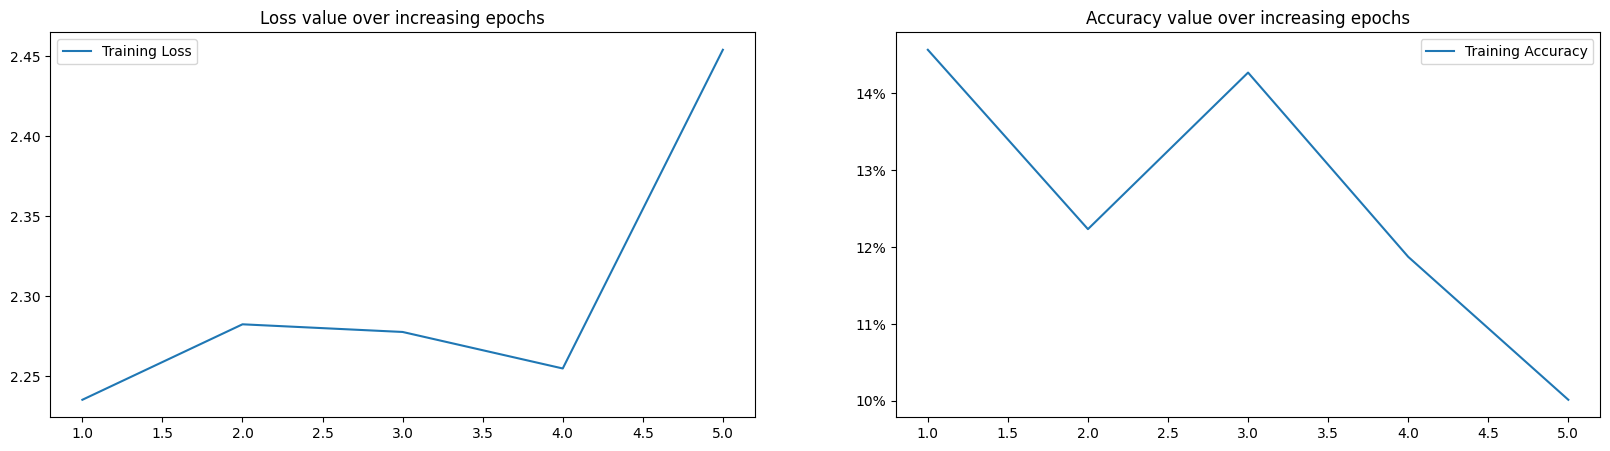

In [23]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()